In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import random
import string
from pathlib import Path
from typing import Callable, List, Tuple

import ipywidgets as widgets
from IPython.display import display, HTML

from fastai.basic_data import DataBunch, DatasetType
from fastai.metrics import accuracy
from fastai.train import Learner
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils

%matplotlib notebook
plt.rcParams["figure.figsize"] = [6, 8]


In [3]:
_DATA_PATH = Path('../data')
_RAW_PATH = _DATA_PATH / 'raw'


In [4]:
def load_dataframes(raw_path):
    df_names = ['train', 'valid', 'test']
    dfs = [pd.read_csv(raw_path/f'{df_name}.csv') for df_name in df_names]
    return dfs


def create_vocab():
    tokens = ['<pad>', '<unk>', '<sos>', '<eos>'] + list(string.printable)
    tok_to_int = {c: i for i, c in enumerate(tokens)}
    int_to_tok = [c for c, i in tok_to_int.items()]
    assert tok_to_int['<pad>'] == 0
    assert tok_to_int['<unk>'] == 1
    assert tok_to_int['<sos>'] == 2
    return tok_to_int, int_to_tok

def build_text_mapper(tok_to_int: dict) -> Callable:
    def mapper(text: str):
        return [tok_to_int['<sos>']] + [tok_to_int.get(c, 1) for c in text] + [tok_to_int['<eos>']]
    return mapper


### Load data and create character -> int mapping

In [5]:
train_df, valid_df, test_df = load_dataframes(_RAW_PATH)
tok_to_int, int_to_tok = create_vocab()


### Define a dataset
Input: 

    encoder input: Noisy date text
    
    decoder input: the standard date text - 1 timestep, include <sos> excludes <eos>
    
output: 

    Standard date text - 1 timestep, include <eos>, excludes <sos>

In [6]:
_MAXLEN = 32

class DateDataset(utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, text_mapper: Callable) -> None:
        self.df = df
        self.x_col = 'input'
        self.y_col = 'output'
        self.maxlen = _MAXLEN
        self.pad_val = 0
        self.text_mapper = text_mapper
        
        self._prepare_data()
    
    def _prepare_data(self):
        self.df['encode_text'] = self.df[self.x_col].apply(self.get_tokens, args=('pre',))
        self.df['decode_text'] = self.df[self.y_col].apply(self.get_tokens, args=('post',))
    
    def __getitem__(self, idx: int):
        sample = self.df.iloc[idx]
        encode_text = sample.encode_text
        decode_text = sample.decode_text
        return {
            'encode_text': encode_text,
            'decode_text': decode_text[:-1],
            'output': decode_text[1:]
        }
    
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def get_tokens(self, text: str, mode: str) -> torch.LongTensor:
        tokens = self.text_mapper(text)
        tokens = self._pad_sequence(tokens, mode)
        return torch.LongTensor(tokens)
    
    def _pad_sequence(self, seq: List, mode: str) -> List:
        diff = self.maxlen - len(seq)
        if diff < 0:
            raise ValueError('Can not pad a sequence longer than maxlen')
        if mode == 'pre':
            return [self.pad_val] * diff + seq
        elif mode == 'post':
            return seq + [self.pad_val] * diff
        else:
            raise ValueError('mode must be pre or post')


def collate_batch(batch: List):
    """Stack each sample together to make a batch."""
    # text will have shape (B, T)
    encode_text = torch.stack([sample['encode_text'] for sample in batch])
    decode_text = torch.stack([sample['decode_text'] for sample in batch])
    # y, needs to be flat to calculate the loss
    # y shape = (B*T, )
    y = torch.cat([sample['output'] for sample in batch])
    return {'encode_text': encode_text, 'decode_text': decode_text}, y


## Create the datasets

In [7]:
text_mapper = build_text_mapper(tok_to_int)

train_ds = DateDataset(train_df, text_mapper)
valid_ds = DateDataset(valid_df, text_mapper)
test_ds = DateDataset(test_df, text_mapper)

data = DataBunch.create(train_ds, valid_ds, test_ds, bs=256, collate_fn=collate_batch, device=torch.device('cuda:0'))

In [8]:
# visualize one batch
data.one_batch()

({'encode_text': tensor([[ 0,  0,  0,  ...,  6,  9,  3],
          [ 0,  0,  0,  ..., 13,  8,  3],
          [ 0,  0,  0,  ..., 11,  5,  3],
          ...,
          [ 0,  0,  0,  ..., 10, 11,  3],
          [ 0,  0,  0,  ..., 11, 11,  3],
          [ 0,  0,  0,  ...,  6,  6,  3]]),
  'decode_text': tensor([[ 2,  5, 12,  ...,  0,  0,  0],
          [ 2,  6,  4,  ...,  0,  0,  0],
          [ 2,  5, 12,  ...,  0,  0,  0],
          ...,
          [ 2,  5, 10,  ...,  0,  0,  0],
          [ 2,  5,  8,  ...,  0,  0,  0],
          [ 2,  5, 13,  ...,  0,  0,  0]])},
 tensor([ 5, 12,  5,  ...,  0,  0,  0]))

# Vanilla RNN/LSTM
![Luong Figure 1.](img/luong_seq2seq.png)

In [9]:
# set model config
_HIDDEN_SIZE = 32
_NUM_LAYERS = 2
_RNN_LAYER = nn.LSTM

### Seq2Seq Model

In [10]:
class SequenceEncoder(nn.Module):
    def __init__(self, tok_to_int: dict) -> None:
        super().__init__()
        self.vocab_size = len(tok_to_int)
        self.hidden_size = _HIDDEN_SIZE
        self.rnn_layers = _NUM_LAYERS

        self.embedding_layer = nn.Embedding(
            self.vocab_size,
            self.hidden_size,
            padding_idx=0
        )
        self.rnn = _RNN_LAYER(
            self.hidden_size,
            self.hidden_size,
            num_layers=self.rnn_layers,
            batch_first=False
        )

    def forward(self, X: torch.LongTensor) -> torch.FloatTensor:
        emb = self.embedding_layer(X)  # (B, T, e)
        emb_t = torch.transpose(emb, 0, 1)  # (T, B, e)
        state = self._init_hidden(emb.size(0))  # init zero state
        emb, state = self.rnn(emb_t, state)  # (T, B, e), ( (num_layers, B, e), (num_layers, B, e) )
        return emb, state

    def _init_hidden(self, batch_size: int) -> Tuple[torch.FloatTensor]:
        h = torch.zeros(self.rnn_layers, batch_size, self.hidden_size)
        if isinstance(self.rnn, nn.RNN):
            return h.to(self.device)
        c = torch.zeros(self.rnn_layers, batch_size, self.hidden_size)
        return h.to(self.device), c.to(self.device)
    
    def get_mask(self, X):
        return (X == 0).float()

    @property
    def device(self):
        return list(self.parameters())[0].device


class SequenceDecoder(nn.Module):
    def __init__(self, tok_to_int: dict) -> None:
        super().__init__()
        self.vocab_size = len(tok_to_int)
        self.hidden_size = _HIDDEN_SIZE
        self.rnn_layers = _NUM_LAYERS
        self.embedding_layer = nn.Embedding(
            self.vocab_size,
            self.hidden_size,
            padding_idx=0
        )
        self.rnn = _RNN_LAYER(
            self.hidden_size,
            self.hidden_size,
            num_layers=self.rnn_layers,
            batch_first = False
        )
        self.h_tilda = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.Tanh()
        )
        self.densor = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, X: torch.LongTensor, encoder_state: Tuple[torch.FloatTensor]):
        X_t = torch.transpose(X, 0, 1)  # (T, B)
        emb_t = self.embedding_layer(X_t)  # (T, B, e)
        emb, state = self.rnn(emb_t, encoder_state)
        emb = self.h_tilda(emb)  # (T, B, e)
        logit = self.densor(emb)  # (T, B, e)
        log_prob = F.log_softmax(logit, dim=-1)  # (T, B, e)
        return log_prob, state


class Seq2Seq(nn.Module):
    def __init__(self, tok_to_int: dict) -> None:
        super().__init__()
        self.tok_to_int = tok_to_int
        self.encoder = SequenceEncoder(tok_to_int)
        self.decoder = SequenceDecoder(tok_to_int)
        
    def forward(self, X: dict):
        teacher_force = random.random() < 0.5
        if teacher_force:
            encoder_out, encoder_state = self.encoder(X['encode_text'])
            decoder_out, decoder_state = self.decoder(X['decode_text'], encoder_state)  # (T, B, e), ...
        else:
            decoder_out, preds = self.predict(X['encode_text'])
        decoder_out = torch.transpose(decoder_out, 0, 1).contiguous()  # (B, T, e)
        return decoder_out.view(-1, self.decoder.vocab_size)

    def predict(self, encode_text):
        B = encode_text.size(0)
        encoder_out, encoder_state = self.encoder(encode_text)
        decoder_text = self._init_decode_text(B)
        state = encoder_state
        decoder_outputs = []  # keep track of log probs for each timestep
        for i in range(_MAXLEN-1):
            x = decoder_text[:, i:i+1]
            decoder_out, state = self._predict_one_step(x, state)
            token_pred = decoder_out.argmax(dim=-1)  # (1, B)
            decoder_outputs.append(decoder_out)
            decoder_text = torch.cat([decoder_text, token_pred.t()], dim=1)
        decoder_out = torch.cat(decoder_outputs, dim=0)  # (T, B, e), log probs for each time step
        return decoder_out, decoder_text
            
    def _predict_one_step(self, decoder_text, state):
        assert decoder_text.size(1) == 1
        decoder_out, decoder_state = self.decoder(decoder_text, state)
        return decoder_out, decoder_state
    
    def _init_decode_text(self, batch_size: int) -> torch.LongTensor:
        sos = torch.zeros(batch_size, 1, dtype=torch.int64).to(self.device)
        sos += 2
        return sos
    
    @property
    def device(self):
        return list(self.parameters())[0].device

In [11]:
def decode_tensor(x: torch.LongTensor, int_to_tok, strip_pad=False):
    if strip_pad:
        return [int_to_tok[i] for i in x if i!=0]
    return [int_to_tok[i] for i in x]

def test_sample(learner, ds_type, idx):
    ds = learner.data.dl(ds_type).dataset
    sample = ds.df.iloc[idx]
    data = ds[idx]
    xb, yb = learner.data.collate_fn([data])
    xb = {k: v.to(learner.data.device) for k, v in xb.items()}
    with torch.no_grad():
        log_prob, pred_labels = learner.model.predict(xb['encode_text'])
        toks = decode_tensor(pred_labels[0], int_to_tok, strip_pad=True)
    decoded = ''.join(toks)
    print('Input:', sample.input)
    print('Expected Output:', sample.output)
    print('Predicted Output:', decoded)

## Train vanilla seq2seq

In [12]:
# define the model and learner
model = Seq2Seq(tok_to_int).to(data.device)
learner = Learner(data, model, loss_func=nn.NLLLoss(), opt_func=optim.Adam, metrics=[accuracy])

In [13]:
# see what the initial output looks like
test_sample(learner, DatasetType.Valid, 27)

Input: Saturday February 23 1771
Expected Output: 1771-02-23
Predicted Output: <sos>VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<IPython.core.display.Javascript object>


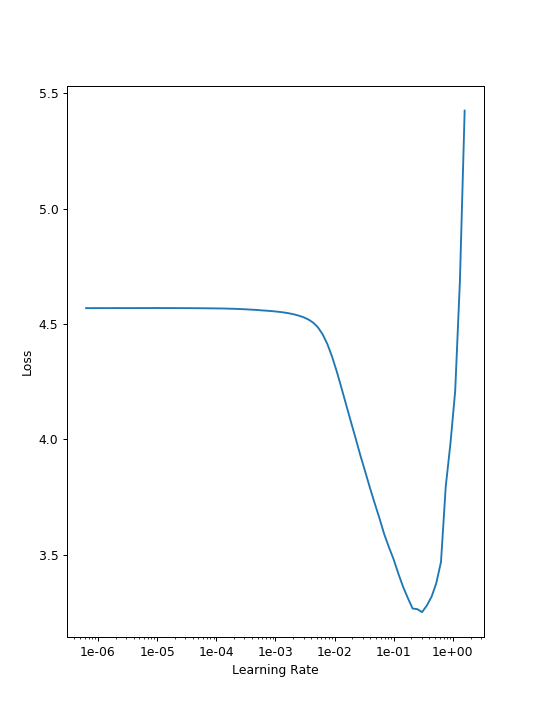

In [14]:
learner.lr_find()
learner.recorder.plot()


In [15]:
learner.fit_one_cycle(2, 1e-1)
learner.fit(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.430482,0.425369,0.825365,00:15
1,0.385679,0.379802,0.849090,00:16


epoch,train_loss,valid_loss,accuracy,time
0,0.310060,0.302587,0.877713,00:15
1,0.242096,0.235436,0.900626,00:15
2,0.188102,0.177548,0.927410,00:16
3,0.110836,0.103634,0.955861,00:15
4,0.056311,0.055643,0.980161,00:15


In [16]:
# see what the post training output looks like
test_sample(learner, DatasetType.Valid, 27)


Input: Saturday February 23 1771
Expected Output: 1771-02-23
Predicted Output: <sos>1771-02-23<eos>


### Define some helper functions to evaluate and visualize the model's output

In [17]:
def make_predictions(learner, ds_type):
    learner.model.eval()
    dl = learner.data.dl(ds_type)
    df = dl.dataset.df
    preds = []
    with torch.no_grad():
        for xb, yb in progress_bar(dl):
            _, pred_labels = learner.model.predict(xb['encode_text'])
            pred_tokens = [decode_tensor(x, int_to_tok, strip_pad=True) for x in pred_labels]
            preds += [''.join(pred) for pred in pred_tokens]
        df['predicted'] = preds
    return df


def eval_df(df) -> float:
    preds = df['predicted'].apply(lambda x: x.rstrip('<eos>').strip('<sos>'))
    perfect = df['output'] == preds
    df['correct'] = perfect
    pct_perfect = perfect.mean()
    return pct_perfect * 100


def decode_text(learner, text: str):
    encode_text = learner.data.valid_ds.get_tokens(text, 'pre').unsqueeze(0)
    encode_text = encode_text.to(learner.data.device)
    learner.model.eval()
    with torch.no_grad():
        _, pred_labels = learner.model.predict(encode_text)
    tokens = decode_tensor(pred_labels[0], int_to_tok, strip_pad=True)
    return ''.join(tokens)


def display_prediction(learner, text: str):
    pred = decode_text(learner, text)
    html_str = '<hr>'
    html_str += f'<font size="5">{text} &rarr; {pred}</font>'
    html_str += '<hr>'
    display(HTML(html_str))

In [18]:
display_prediction(learner, 'December 25 1991')


In [19]:
train_df = make_predictions(learner, DatasetType.Fix)
valid_df = make_predictions(learner, DatasetType.Valid)
test_df = make_predictions(learner, DatasetType.Test)

In [20]:
print('** Perfect transcriptions **')
print(f'Train accuracy: {eval_df(train_df):0.2f}%')
print(f'Valid accuracy: {eval_df(valid_df):0.2f}%')
print(f'Test accuracy: {eval_df(test_df):0.2f}%')

** Perfect transcriptions **
Train accuracy: 79.27%
Valid accuracy: 78.75%
Test accuracy: 79.14%


In [21]:
valid_df[['input', 'output', 'predicted']]

,input,output,predicted
0,"December 16, 1836",1836-12-16,<sos>1836-12-16<eos>
1,16-8-1656,1656-08-16,<sos>1656-08-16<eos>
2,Oct 22 1699,1699-10-22,<sos>1699-10-22<eos>
3,2088-12-8,2088-12-08,<sos>2088-12-08<eos>
4,1617/5/2,1617-05-02,<sos>1617-05-02<eos>
...,...,...,...
9995,"Aug 17, 1944",1944-08-17,<sos>1944-08-17<eos>
9996,7/10/1884,1884-07-10,<sos>1884-07-10<eos>
9997,1625/2/1,1625-02-01,<sos>1625-02-01<eos>
9998,Oct 9 1885,1885-10-09,<sos>1885-10-09<eos>


## Seq2Seq w/ Luong Attention

https://arxiv.org/pdf/1508.04025.pdf

This implementation if of Luong's dot attention. 

![Luong Figure 2.](img/luong_attn.png)

The challenge in vanilla Seq2Seq is that a lot of information is lost between the encoder and decoder. This is seen as a single fixed-length vector (the encoder's hidden state) being passed to the decoder. This forces the decoder to translate the encoded message withdegraded

The attention mechanism allows you to "focus" on a particular peice of context given a query. This is commonly seen in neural machine translation (NMT). In NMT, the "context" is set by the encoder

#### The attention mechanism

In [ ]:
def attention(
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor = None,
        mask: torch.Tensor = None,
        dropout_rate: float = 0.0,
        scale: bool = False,
        training: bool = False,
    ) -> Tuple[torch.Tensor]:
    """Compute attention weights and values.

    A combination of the value tensor for each time step in query.

    Attention weights are computed via dot product.

    Parameters
    ----------
    query : torch.Tensor
        shape (batch_size, Tq, dim)
    key : torch.Tensor
        shape (batch_size, Tv, dim)
    value : torch.Tensor
        shape (batch_size, Tv, dim), by default None will use `key` tensor
    mask : torch.Tensor, optional
        Shape must be broadcastable to (batch_size, Tq, Tv), by default None
    dropout_rate: float, optional
        apply dropout to attention scores before softmax, by default 0.0
    scale : bool, optional
        scale the attention scores by 1./sqrt(dim), by default False
    training: bool, optional
        training or evaluation mode, set by passing `model.training`, by default False

    Returns
    -------
    Tuple[torch.Tensor]
        A linear combination of the value tensor for each time step in query.
    """
    if value is None: value = key
    B, Tq, dim = query.size()
    Tv = value.size(1)
    # Section 3.1 Global Attention -> "dot"
    attn_scores = torch.bmm(query, torch.transpose(key, 1, 2))  #  (B, Tq, Tv)
    attn_scores = F.dropout(attn_scores, dropout_rate, training, False)  # (B, Tq, Tv)
    if scale:
        attn_scores /= math.sqrt(dim)
    if mask is not None:
        attn_scores -= (mask * 1e9)
    attn_weights = F.softmax(attn_scores, dim=-1)  #  Eq. 8, (B, Tq, Tv)
    output = torch.bmm(attn_weights, value)  # (B, Tq, e)
    return output, attn_weights

### Seq2Seq w/ Luong Attention

In [20]:
class AttnSequenceDecoder(nn.Module):
    def __init__(self, tok_to_int: dict) -> None:
        super().__init__()
        self.vocab_size = len(tok_to_int)
        self.hidden_size = _HIDDEN_SIZE
        self.rnn_layers = _NUM_LAYERS
        self.embedding_layer = nn.Embedding(
            self.vocab_size,
            self.hidden_size,
            padding_idx=0
        )
        self.rnn = _RNN_LAYER(
            2*self.hidden_size,
            self.hidden_size,
            num_layers=self.rnn_layers,
            batch_first = False
        )
        self.h_tilda = nn.Sequential(nn.Linear(2*self.hidden_size, self.hidden_size), nn.Tanh())  # Eq. 5
        self.densor = nn.Linear(self.hidden_size, self.vocab_size)  # Eq. 6

    def apply_attention(self, X: torch.FloatTensor, encoder_output: torch.FloatTensor, encoder_mask: torch.Tensor):
        encoder_output = torch.transpose(encoder_output, 0, 1)  # (B, Tv, e)
        context, attn_weights = attention(
            query=X,
            key=encoder_output,
            value=encoder_output,
            mask=encoder_mask.unsqueeze(1),  # (B, 1, Tv)
            dropout_rate=0.,
            scale=False,
            training=self.training
        )  # (B, Tq, e), (B, Tq, Tv)
        return context, attn_weights
    
    def forward_onestep(
        self, 
        X: torch.LongTensor,
        state: Tuple[torch.Tensor],
        context: torch.FloatTensor, 
        encoder_output: torch.FloatTensor,
        encoder_mask: torch.Tensor
    ) -> Tuple[torch.Tensor]:
        assert X.size(1) == 1
        B = X.size(0)
        emb = self.embedding_layer(X)  # (B, 1, e)
        emb = torch.cat([emb, context], dim=2)  # (B, 1, 2e)
        emb_t = torch.transpose(emb, 0, 1)  # (1, B, 2e)
        emb_t, state = self.rnn(emb_t, state)  # (1, B, e)
        emb = torch.transpose(emb_t, 0, 1)  # (B, 1, e)
        context, attn_weights = self.apply_attention(emb, encoder_output, encoder_mask)  # (B, 1, e), (B, 1, Tv)
        
        # Figure 4, "Attentional vectors h_tilda are fed as inputs to the next time steps"
        h = torch.cat([emb, context], dim=2)
        next_context = self.h_tilda(h)  # (B, 1, e)
        logit = self.densor(next_context)  # (B, 1, vocab_size)
        log_prob = F.log_softmax(logit, dim=-1)
        return log_prob, next_context, state, attn_weights

    def forward(
        self, 
        X: torch.LongTensor,
        state: Tuple[torch.Tensor],
        context: torch.FloatTensor, 
        encoder_output: torch.FloatTensor,
        encoder_mask: torch.Tensor
    ) -> Tuple[torch.Tensor]:
        
        log_probs = []
        attn_weights = []
        for i in range(X.size(1)):
            Xt = X[:, i:i+1]
            log_prob, context, state, attn = self.forward_onestep(
                Xt,
                state,
                context,
                encoder_output,
                encoder_mask
            )
            log_probs.append(log_prob)
            attn_weights.append(attn)
        log_probs = torch.cat(log_probs, dim=1)
        attn_weights = torch.cat(attn_weights, dim=1)
        return log_probs, state, attn_weights

    def _init_hidden(self, batch_size: int) -> Tuple[torch.FloatTensor]:
        h = torch.zeros(self.rnn_layers, batch_size, self.hidden_size)
        if isinstance(self.rnn, nn.RNN):
            return h.to(self.device)
        c = torch.zeros(self.rnn_layers, batch_size, self.hidden_size)
        return [h.to(self.device), c.to(self.device)]
    
    def _init_context(self, batch_size: int) -> torch.FloatTensor:
        c = torch.zeros(batch_size, 1, self.hidden_size)
        return c.to(self.device)

    def get_mask(self, X):
        return (X == 0).float()

    @property
    def device(self):
        return list(self.parameters())[0].device


class AttnSeq2Seq(nn.Module):
    def __init__(self, tok_to_int: dict) -> None:
        super().__init__()
        self.tok_to_int = tok_to_int
        self.encoder = SequenceEncoder(tok_to_int)
        self.decoder = AttnSequenceDecoder(tok_to_int)

    def forward(self, X: dict):
        teacher_force = random.random() < 0.5
        if teacher_force:
            B = X['encode_text'].size(0)
            encoder_mask = self.encoder.get_mask(X['encode_text'])
            encoder_out, encoder_state = self.encoder(X['encode_text'])
            state, context = self.decoder._init_hidden(B), self.decoder._init_context(B)
            log_prob, decoder_state, attn_weights = self.decoder(
                X['decode_text'], state, context, encoder_out, encoder_mask
            )  # (B, T, e), ...
        else:
            log_prob, decoder_text, attn_weights = self.predict(X['encode_text'])
        return log_prob.view(-1, self.decoder.vocab_size)

    def predict(self, encode_text):
        B, Tv = encode_text.size(0), encode_text.size(1)
        encoder_out, encoder_state = self.encoder(encode_text)
        encoder_mask = self.encoder.get_mask(encode_text)
        decoder_text = self._init_decode_text(B)
        state, context = self.decoder._init_hidden(B), self.decoder._init_context(B)
        log_probs = []  # keep track of log probs for each timestep
        attn_weights = [torch.zeros(B, 1, Tv).to(self.device)]  # keep track of the attn weights for each timestep
        for i in range(_MAXLEN - 1):
            Xt = decoder_text[:, i:i+1]
            log_prob, context, state, attn = self.decoder.forward_onestep(
                Xt, state, context, encoder_out, encoder_mask
            )  # (B, 1, vocab_size), ...
            log_probs.append(log_prob)
            attn_weights.append(attn)
            token_pred = log_prob.argmax(dim=-1)  # (B, 1)
            decoder_text = torch.cat([decoder_text, token_pred], dim=1)
        attn_weights = torch.cat(attn_weights, dim=1)  # (B, T, T)
        log_probs = torch.cat(log_probs, dim=1)  # (B, T, e), log probs for each time step
        return log_probs, decoder_text, attn_weights

    def _predict_one_step(self, decoder_text, state, encoder_output, encoder_mask):
        assert decoder_text.size(1) == 1
        decoder_out, decoder_state, attn_weights = self.decoder(decoder_text, state, encoder_output, encoder_mask)
        return decoder_out, decoder_state, attn_weights

    def _init_decode_text(self, batch_size: int) -> torch.LongTensor:
        sos = torch.zeros(batch_size, 1, dtype=torch.int64).to(self.decoder.device)
        sos += 2
        return sos
    
    @property
    def device(self):
        return list(self.parameters())[0].device

In [21]:
def test_sample(learner, ds_type, idx):
    ds = learner.data.dl(ds_type).dataset
    sample = ds.df.iloc[idx]
    data = ds[idx]
    xb, yb = learner.data.collate_fn([data])
    xb = {k: v.to(learner.data.device) for k, v in xb.items()}
    with torch.no_grad():
        log_prob, pred_labels, attn = learner.model.predict(xb['encode_text'])
        attn = attn[0]
    toks = decode_tensor(pred_labels[0], int_to_tok, strip_pad=True)
    decoded = ''.join(toks)
    decode_text = decode_tensor(pred_labels[0], int_to_tok, strip_pad=True)
    encode_text = decode_tensor(xb['encode_text'][0], int_to_tok, strip_pad=True)
    imshow_attn(attn, encode_text, decode_text)
    print('Input:', sample.input)
    print('Expected Output:', sample.output)
    print('Predicted Output:', decoded)
    return attn

def imshow_attn(attn: torch.FloatTensor, encode_text, decode_text):
    ne, nd = len(encode_text), len(decode_text)
    attn_vals = attn.cpu().numpy()[0:nd, -ne:].T
    #attn_vals = attn_vals[::-1, :]
    plt.imshow(attn_vals, cmap='gray')
    plt.yticks(np.arange(len(encode_text)), encode_text)
    plt.xticks(np.arange(len(decode_text)), decode_text, rotation=45)
    plt.xlabel('Output Text')
    plt.ylabel('Input text')
    plt.show()

## Train the seq2seq w/ attention model

In [53]:
model = AttnSeq2Seq(tok_to_int).to(data.device)
learner = Learner(data, model, loss_func=nn.NLLLoss(), opt_func=optim.Adam, metrics=[accuracy])

<IPython.core.display.Javascript object>


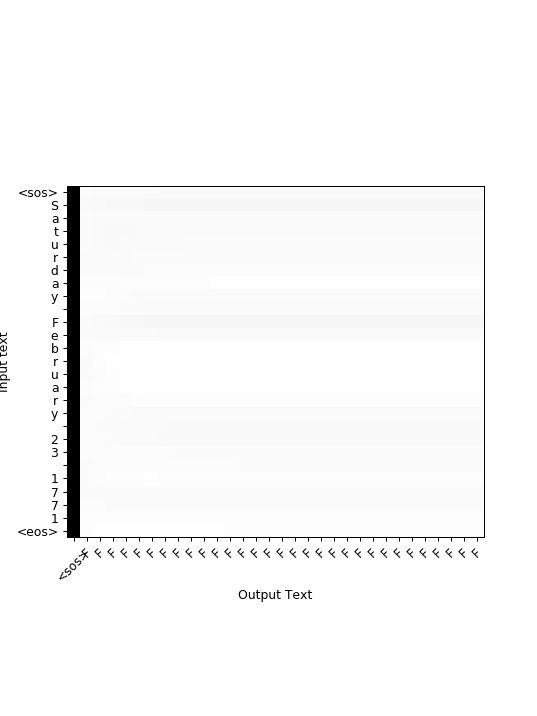

Input: Saturday February 23 1771
Expected Output: 1771-02-23
Predicted Output: <sos>FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


In [54]:
# see what the initial output looks like
attn = test_sample(learner, DatasetType.Valid, 27)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<IPython.core.display.Javascript object>


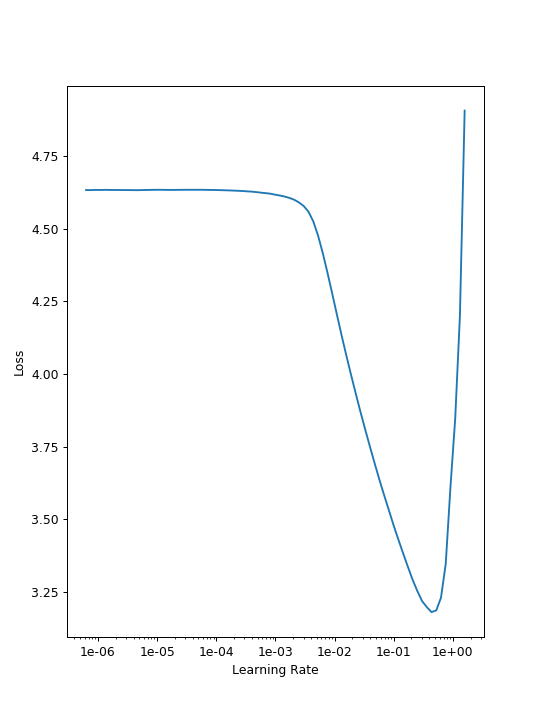

In [55]:
learner.lr_find()
learner.recorder.plot()

In [56]:
learner.fit_one_cycle(2, 3e-2)
learner.fit(5, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.452836,0.429005,0.829839,00:28
1,0.283416,0.280699,0.880806,00:28


epoch,train_loss,valid_loss,accuracy,time
0,0.097979,0.073553,0.975536,00:27
1,0.023881,0.023474,0.992765,00:28
2,0.017820,0.017714,0.993387,00:28
3,0.017004,0.020090,0.992348,00:28
4,0.015934,0.016081,0.993481,00:27


<IPython.core.display.Javascript object>


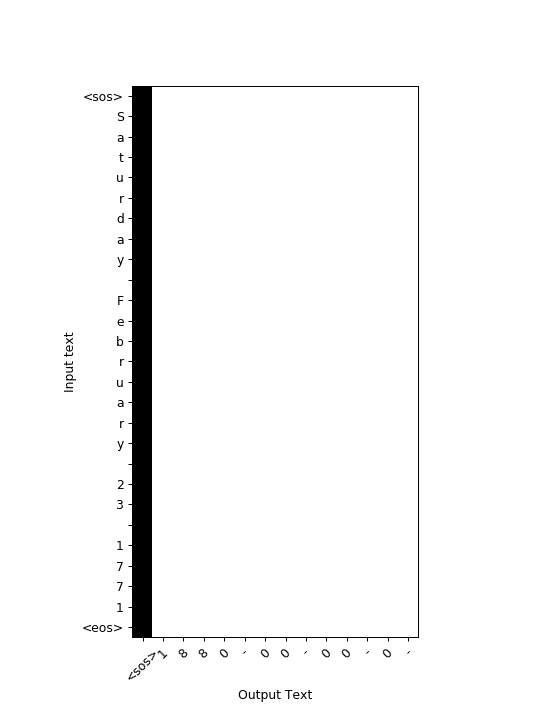

Input: Saturday February 23 1771
Expected Output: 1771-02-23
Predicted Output: <sos>1880-00-00-0-


In [51]:
# see what the post training output looks like
attn = test_sample(learner, DatasetType.Valid, 27)

In [45]:
def decode_text(learner, text: str):
    encode_text = learner.data.valid_ds.get_tokens(text, 'pre').unsqueeze(0)
    encode_text = encode_text.to(learner.data.device)
    learner.model.eval()
    with torch.no_grad():
        log_probs, pred_labels, attn = learner.model.predict(encode_text)
        attn = attn[0]
        pred_labels = pred_labels[0]
    toks = decode_tensor(pred_labels, int_to_tok, strip_pad=True)
    decoded = ''.join(toks)
    decode_text = decode_tensor(pred_labels, int_to_tok, strip_pad=True)
    encode_text = decode_tensor(encode_text[0], int_to_tok, strip_pad=True)
    imshow_attn(attn, encode_text, decode_text)
    tokens = decode_tensor(pred_labels, int_to_tok, strip_pad=True)
    return ''.join(tokens)


def display_prediction(learner, text: str):
    pred = decode_text(learner, text)
    html_str = '<hr>'
    html_str += f'<font size="5">{text} &rarr; {pred}</font>'
    html_str += '<hr>'
    display(HTML(html_str))

<IPython.core.display.Javascript object>


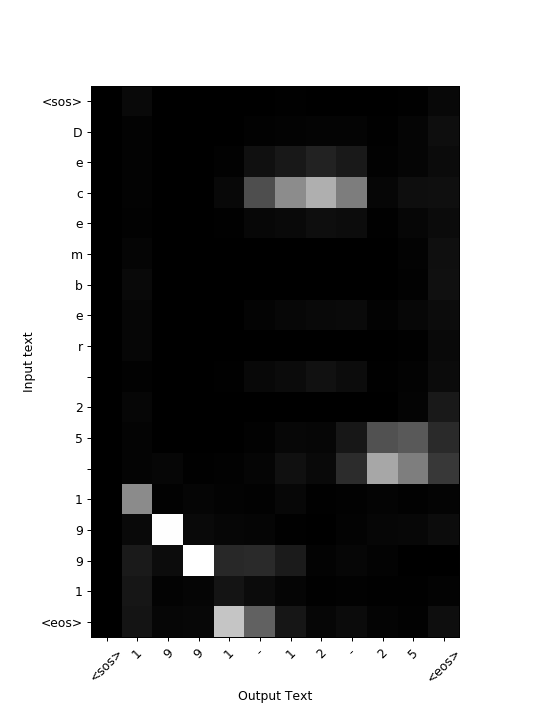

In [46]:
display_prediction(learner, 'December 25 1991')